## Variational Classifier

In [1]:
# Import libraries
import pandas as pd               # Data manipulation

import matplotlib.pyplot as plt   # Plotting
import seaborn as sns             # Advanced plotting

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)



import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer



from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


### Loading in the Datasets

In [2]:
# Load datasets
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
gender_submission = pd.read_csv('dataset/gender_submission.csv')

# Display first few rows of training data
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Load the Titanic dataset
import pandas as pd

data = train

# Basic preprocessing
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Fare'] = data['Fare'].fillna(data['Fare'].median())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
data['Sex'] = LabelEncoder().fit_transform(data['Sex'])

# Create FamilySize feature
data['FamilySize'] = data['SibSp'] + data['Parch']

# Select features and target
features = ['Sex', 'Age', 'Fare', 'Pclass', 'FamilySize']
X = data[features]
y = data['Survived']

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Normalize features to [0, π]
X_train = (X_train - np.min(X_train, axis=0)) / (np.max(X_train, axis=0) - np.min(X_train, axis=0)) * np.pi
X_test = (X_test - np.min(X_test, axis=0)) / (np.max(X_test, axis=0) - np.min(X_test, axis=0)) * np.pi


In [5]:
print(X_train)

[[3.14159265 1.77963052 0.17476144 0.         0.        ]
 [3.14159265 0.89139435 0.07971575 1.57079633 0.        ]
 [3.14159265 1.24668882 0.04859595 3.14159265 0.        ]
 ...
 [3.14159265 1.60198329 0.08651182 3.14159265 0.62831853]
 [0.         0.53609988 0.73583766 0.         0.9424778 ]
 [3.14159265 0.81244002 0.47392544 0.         0.31415927]]


### Quantum State Preparation

Every inpyt $x$ has to be translated into set of angles which can get fed into small routines for state preparation.

In [6]:
n_qubits = len(features)  # Number of qubits based on features
n_layers = 5  # Number of variational layers

# Define a quantum device
dev = qml.device("default.qubit", wires=n_qubits)


# Define the variational circuit with increased depth
def variational_circuit(weights, x):
    for i in range(len(x)):
        qml.RX(x[i], wires=i)  # Embed input data
    for layer in weights:
        for i in range(len(x)):
            qml.Rot(layer[i][0], layer[i][1], layer[i][2], wires=i)  # Rotational gates
        for i in range(len(x) - 1):
            qml.CNOT(wires=[i, i + 1])  # Add entanglement


# Define the quantum node
@qml.qnode(dev)
def quantum_node(weights, x):
    variational_circuit(weights, x)
    return qml.expval(qml.PauliZ(0))  # Binary classification output


In [7]:
def variational_classifier(weights, bias, x):
    raw_output = quantum_node(weights, x) + bias
    probability = (raw_output + 1) / 2  # Scale to [0, 1]
    return probability


In [8]:
def cross_entropy_loss(labels, predictions):
    """Compute cross-entropy loss using qml.numpy for compatibility."""
    predictions = qml.numpy.array(predictions)  # Ensure predictions are qml.numpy arrays
    predictions = qml.numpy.clip(predictions, 1e-10, 1 - 1e-10)  # Avoid log(0)
    return -qml.numpy.mean(labels * qml.numpy.log(predictions) + (1 - labels) * qml.numpy.log(1 - predictions))

def regularized_cost(weights, bias, X, y, lambda_reg=0.01):
    """Regularized cost function."""
    predictions = [variational_classifier(weights, bias, x) for x in X]
    predictions = qml.numpy.array(predictions)  # Convert predictions to qml.numpy array
    base_cost = cross_entropy_loss(y, predictions)
    reg_cost = lambda_reg * qml.numpy.sum(qml.numpy.square(weights))  # L2 regularization
    #print(f"Predictions: {predictions}, Type: {type(predictions)}")
    return base_cost + reg_cost


# Actual cost (without regularization) for monitoring
def cost(weights, bias, X, y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return cross_entropy_loss(y, predictions)


In [9]:
# Initialize weights and bias
n_layers = 10  # Increase from 5 to 10
weights = np.random.uniform(low=-0.05, high=0.05, size=(n_layers, n_qubits, 3), requires_grad=True)

bias = np.array(0.0, requires_grad=True)

# Define the optimizer
opt = qml.AdamOptimizer(stepsize=0.005)
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
# Store metrics for plotting
train_costs, val_accuracies = [], []

# Training parameters
batch_size = 10
num_epochs = 20
lambda_reg = 0.01  # Regularization strength

from sklearn.metrics import accuracy_score

# Training loop with validation accuracy tracking
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        X_train, y_train = shuffle(X_train, y_train)  # Shuffle training data
        X_batch = qml.numpy.array(X_train[i:i + batch_size])  # Convert batch to qml.numpy array
        y_batch = qml.numpy.array(y_train[i:i + batch_size])  # Convert labels to qml.numpy array

        # Update weights and bias using the regularized cost
        weights, bias = opt.step(lambda w, b: regularized_cost(w, b, X_batch, y_batch, lambda_reg), weights, bias)

    # Compute training costs for monitoring
    train_cost_regularized = regularized_cost(weights, bias, X_train, y_train, lambda_reg)
    train_cost_actual = cost(weights, bias, X_train, y_train)

    # Compute validation accuracy
    val_predictions = [np.round(variational_classifier(weights, bias, x)) for x in X_test]  # Binary predictions (0 or 1)
    val_accuracy = accuracy_score(y_test, val_predictions)

    # Store metrics
    train_costs.append(train_cost_actual)
    val_accuracies.append(val_accuracy)
    # Print metrics
    print(
        f"Epoch {epoch + 1}: Regularized Cost = {train_cost_regularized:.4f}, "
        f"Actual Cost = {train_cost_actual:.4f}, Validation Accuracy = {val_accuracy:.4f}"
    )





Epoch 1: Regularized Cost = 0.5347, Actual Cost = 0.5261, Validation Accuracy = 0.7821
Epoch 2: Regularized Cost = 0.4974, Actual Cost = 0.4824, Validation Accuracy = 0.7821
Epoch 3: Regularized Cost = 0.4898, Actual Cost = 0.4735, Validation Accuracy = 0.7821
Epoch 4: Regularized Cost = 0.4819, Actual Cost = 0.4624, Validation Accuracy = 0.7821
Epoch 5: Regularized Cost = 0.4757, Actual Cost = 0.4565, Validation Accuracy = 0.7821
Epoch 6: Regularized Cost = 0.4723, Actual Cost = 0.4523, Validation Accuracy = 0.7821
Epoch 7: Regularized Cost = 0.4674, Actual Cost = 0.4460, Validation Accuracy = 0.7821
Epoch 8: Regularized Cost = 0.4638, Actual Cost = 0.4444, Validation Accuracy = 0.7821
Epoch 9: Regularized Cost = 0.4628, Actual Cost = 0.4407, Validation Accuracy = 0.7877
Epoch 10: Regularized Cost = 0.4596, Actual Cost = 0.4369, Validation Accuracy = 0.7877
Epoch 11: Regularized Cost = 0.4645, Actual Cost = 0.4423, Validation Accuracy = 0.7989
Epoch 12: Regularized Cost = 0.4644, Actu

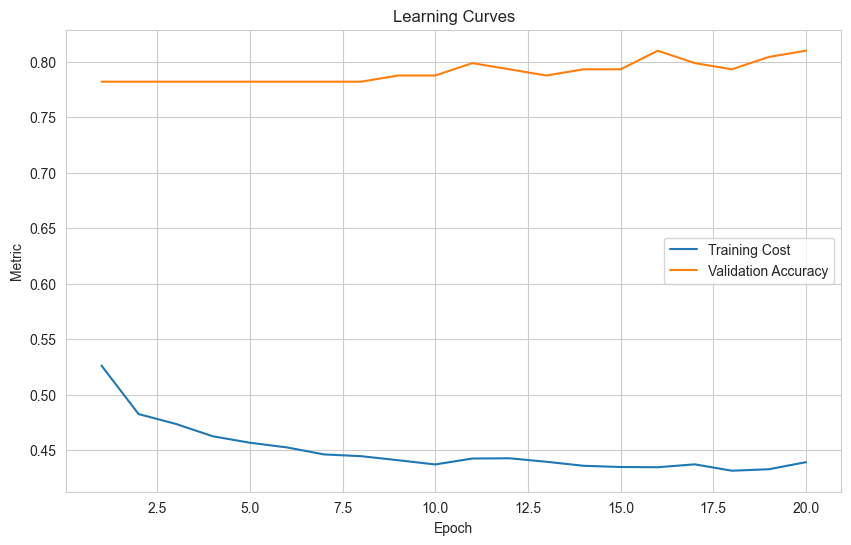

In [10]:
# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_costs, label="Training Cost")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Learning Curves")
plt.legend()
plt.show()


In [12]:
import pandas as pd

# Load the test dataset
test_data = pd.read_csv("dataset/test.csv")

# Preprocess the test dataset (similar to the training dataset)
test_data['Age'] = test_data['Age'].fillna(data['Age'].median())
test_data['Fare'] = test_data['Fare'].fillna(data['Fare'].median())
test_data['Embarked'] = test_data['Embarked'].fillna(data['Embarked'].mode()[0])
test_data['Sex'] = LabelEncoder().fit_transform(test_data['Sex'])

# Create FamilySize feature
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch']

# Select the same features used during training
features = ['Sex', 'Age', 'Fare', 'Pclass', 'FamilySize']
X_submission = test_data[features]

# Scale the features using the same scaler as for training
X_submission = scaler.transform(X_submission)

# Predict using the trained quantum classifier
submission_predictions = [np.round(variational_classifier(weights, bias, x)) for x in X_submission]

# Generate the submission file
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': [int(pred) for pred in submission_predictions]  # Convert to integer
})

# Save to CSV
submission.to_csv('submission_vqc.csv', index=False)
print("Submission file 'submission_vqc.csv' created.")


Submission file 'submission_vqc.csv' created.
